## Machine Learning approach for classification of SARS-CoV-2 variants

#Trying another tutorial using this [approach](https://www.kaggle.com/zakarii/dna-sequence-classification-cnn-gru)

Import and Load libraries

In [2]:
import pandas as pd
import numpy as np
import os

import joblib

from keras import utils as np_utils
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, MaxPooling2D, Conv2D, LSTM, GRU, Bidirectional
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
import keras

from keras import utils as np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from numpy import array

### **Data Pre-processing** 
Download dataset from this [link](https://drive.google.com/file/d/1BnxovEnbwflFGKKLHomOx4RFQUdDKG55/view?usp=sharing)

In [3]:
dataset_1 = pd.read_table("../data/variants.aln4.fas.txt", usecols=[1,2] ) #initial dataset with 86 sequneces
dataset_2 = '../data/sequences.aln.fas' # huge dataset with 26k sequences

In [4]:
#Converting sequence data into data frame
#Ensure the fasta sequences are in one-liner and not blocks
#The sequence file had been pre-processed to include varinat names in the sequnce headers. Check file in fasta format.

inputfile = dataset_2

lines = []
header = []
with open (inputfile, 'r') as fasta_file:
    
    for line in fasta_file:
        if line.startswith(">"):
            #extract fasta headers
            lines.append(line.replace('\w', '').replace(">", "").replace("\n", ''))
            
        next
            #extract sequence lines
        if not line.startswith(">"):
            header.append(line.replace("\n",''))

#Create dictionary of header and sequences and create a datafram
data = {lines[i]:header[i] for i in range(len(header))}
data = pd.DataFrame(list(data.items()),columns = ['Seq_ID','sequence']) 


data["sequence"] = data["sequence"].str.upper() #ensure the sequence is un uppercase. Important for encoding

data["Variant_Id"] = data["Seq_ID"].apply(lambda i: i.split('/')[0]) #extracting variant names from sequnce file

data = data.drop("Seq_ID", axis=1)

dataset_1["sequence"] = dataset_1['sequence'].str.upper() 

dataset_2 = data

dataset = [dataset_1, dataset_2]

### Assign variant name to numerical form

gamma - 0 \
delta - 1 \
beta - 2 \
alpha - 3 \
omicron - 4

In [5]:

def variant_annotation(dataset):
    variant = {"gamma" : 0, "delta" : 1, "beta" : 2, "alpha" : 3, "omicron":4}

    for seq_data in dataset:
        seq_data["Variant_Id"] = seq_data["Variant_Id"].map(variant)
    return dataset

variant_annotation(dataset)

dataset_1.head()

,sequence,Variant_Id
0,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
1,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
2,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
3,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0
4,ATGTTTGTTTTTCTTGTTTTATTGCCACTAGTCTCTAGTCAGTGTG...,0


In [6]:


def encode_seq(seq_data):
    """
    Function to convert nucleotides to binary form and hot-encoded

    Arguments :
    seq_data = sequence dataframe with "sequence" and "Variant_ID" columns

    char : total number of unique characters in the whole dataset. This is used to 
    bin : array list of zeros corresponding to the number of characters

    """

    ntds = []
    for i in seq_data['sequence']:
        for seq in i:
            ntd = seq.strip()
            ntds.append(ntd.upper())
        
    char = list(set(ntds))
    
    bin = [0] * len(char)
    bin0  = [0] * len(char)
    bin1  = [0] * len(char)
    bin2  = [0] * len(char)
    bin3  = [0] * len(char)
    
    #Create a dictionary of arrays to the seqeunce characters
    Encode = {}

    for i in char:
        if i == 'A':
            bin0[0] = 1
            Encode[i] = bin0
        elif i == 'C':
            bin1[1] = 1
            Encode[i] = bin1
        elif i == 'G':
            bin2[2] = 1
            Encode[i] = bin2
        elif i == 'T':
            bin3[3] = 1
            Encode[i] = bin3
        else:
            Encode[i] = bin
    
      #convert the sequence characters to encoded form and append to the list

    encoded_list = []

    for seq in seq_data["sequence"]:
        encoded_list.append([Encode[x] for x in seq])

    return encoded_list

### **Convert sequence to binary form (Non-kmerized)**

In [8]:
#RUn the function to encode the sequence dataset. Create an array of the binary in numpy form
Encoded_dataset_1 = encode_seq(dataset_1)
X_mine_data1 = np.array(Encoded_dataset_1)
X_mine_data1.shape

y_mine = dataset_1["Variant_Id"]

In [9]:
#Encoded_dataset_2 = encode_seq(dataset_2)
#X_mine_data2 = np.array(Encoded_dataset_2)
#X_mine_data2.shape

(26037, 3874, 13)

In [12]:
#Encoded_dataset_2[1][1]

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]

## **Performing K-Merization**
This is with the purpose of testing whether k-merization improves performance of the model.

In [9]:
#Get a copy of the dataset

dataset_1_k = dataset_1.copy()
dataset_2_k = dataset_2.copy()

kmer_data = [dataset_1_k, dataset_2_k]

In [10]:

def getKmers(sequence, size=4):
    """"
    function to convert sequence strings into k-mer words, default size = 4 (hexamer words)

    Arguments:
    sequence = sequnce set 
    size = size of kmers 
    """
    return [sequence[x:x+size].upper() for x in range(len(sequence) - size + 1)]

for seq_data in kmer_data:
    seq_data['sequence'] = seq_data.apply(lambda x: getKmers(x['sequence']), axis=1)

In [28]:
dataset_1_k.head()

,sequence,Variant_Id
0,"[ATGT, TGTT, GTTT, TTTG, TTGT, TGTT, GTTT, TTT...",0
1,"[ATGT, TGTT, GTTT, TTTG, TTGT, TGTT, GTTT, TTT...",0
2,"[ATGT, TGTT, GTTT, TTTG, TTGT, TGTT, GTTT, TTT...",0
3,"[ATGT, TGTT, GTTT, TTTG, TTGT, TGTT, GTTT, TTT...",0
4,"[ATGT, TGTT, GTTT, TTTG, TTGT, TGTT, GTTT, TTT...",0


In [11]:
#binary encode kmerized dataset 
encoded = encode_seq(dataset_1_k)
X_mine_data_kmer_1 = np.array(encoded)
X_mine_data_kmer_1.shape

(86, 3828, 303)

In [55]:
#enc2 = encode_seq(dataset_2_k)
#X_mine_data_kmer_2 = np.array(enc2)
#X_mine_data_kmer_2.shape

In [12]:
y_mine_kmer_1 = dataset_1_k['Variant_Id']
y_mine_kmer_1.shape

(86,)

## **Model Fitting**
### Split dataset into training and validation
Use data specific to each variable above.

In [16]:
#Split dataset into training and validation
X_train, X_test, y_train, y_test = train_test_split(X_mine_data_kmer_1, y_mine_kmer_1, random_state = 42, stratify = y_mine_kmer_1)

#have the data in tensor-readable form. I also don't know what that means.
y_train = keras.utils.np_utils.to_categorical(y_train)
y_test = keras.utils.np_utils.to_categorical(y_test)

**!Ensure you change the input_shape suitable for the data you running**

In [14]:
#Model parameter setting

params = {
    'first_node': [128, 64],
    'second_node': [32, 64],
    'alpha': [0.001, 0.01],
    'first_filter': [9, 16, 32], 
    'dropout': [0.1, 0.2, 0.5]
}

gru_model = Sequential()

#Layer 1 - feature extraction
#Performs dimension reduction

gru_model.add(Conv1D(filters = 27, kernel_size = (4), activation = 'relu', input_shape = X_mine_data_kmer_1.shape[1:])) #ensure you change the shape
gru_model.add(MaxPooling1D(pool_size= (3)))
gru_model.add(Dropout(0.2))
gru_model.add(Conv1D(filters = 14, kernel_size = (2), activation = 'relu', padding = 'same'))


gru_model.add(Bidirectional(GRU(128, activation = 'relu')))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(128, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(64, activation = 'relu'))
gru_model.add(Dense(16, activation = 'relu', kernel_regularizer = regularizers.l2(0.01)))
gru_model.add(Dense(5, activation = 'softmax'))

gru_model.add(Flatten())

gru_model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

2022-04-13 15:39:49.224785: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3825, 27)          32751     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1275, 27)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1275, 27)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1275, 14)          770       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              110592    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.0005, patience=8, 
                                           restore_best_weights=True )
history = gru_model.fit(X_train, y_train, batch_size = 128, validation_data=(X_test, y_test), 
                        epochs=10)

Epoch 1/10
1/1 [==============================] - 24s 24s/step - loss: 3.0017 - accuracy: 0.2188 - val_loss: 3.0697 - val_accuracy: 0.2273
Epoch 2/10
1/1 [==============================] - 12s 12s/step - loss: 2.9988 - accuracy: 0.2188 - val_loss: 3.0669 - val_accuracy: 0.2273
Epoch 3/10
1/1 [==============================] - 11s 11s/step - loss: 2.9960 - accuracy: 0.2188 - val_loss: 3.0641 - val_accuracy: 0.2273
Epoch 4/10
1/1 [==============================] - 11s 11s/step - loss: 2.9932 - accuracy: 0.2188 - val_loss: 3.0613 - val_accuracy: 0.2273
Epoch 5/10
1/1 [==============================] - 9s 9s/step - loss: 2.9904 - accuracy: 0.2188 - val_loss: 3.0585 - val_accuracy: 0.2273
Epoch 6/10
1/1 [==============================] - 9s 9s/step - loss: 2.9876 - accuracy: 0.2188 - val_loss: 3.0558 - val_accuracy: 0.2273
Epoch 7/10
1/1 [==============================] - 16s 16s/step - loss: 2.9849 - accuracy: 0.2188 - val_loss: 3.0531 - val_accuracy: 0.2273
Epoch 8/10
1/1 [===============

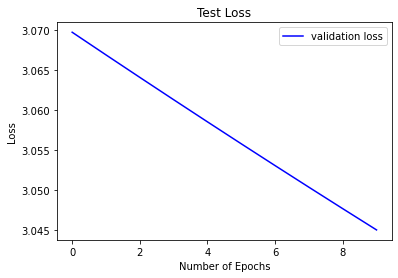

In [17]:
# Plot the loss and accuracy curves for training and validation 

import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### **Model Validation**

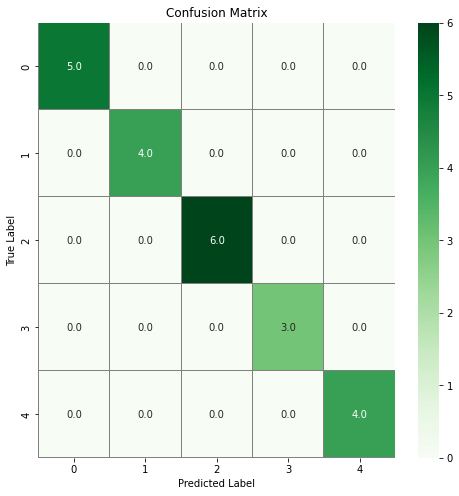

In [18]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the values from the validation dataset
Y_pred = gru_model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(y_test,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()